In [1]:
!pip install k-wave-python

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from kwave.data import Vector
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.checks import check_stability
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksource import kSource
from kwave.ksensor import kSensor
from kwave.utils.signals import create_cw_signals
from kwave.utils.filters import extract_amp_phase
from kwave.kspaceFirstOrder2D import kspace_first_order_2d_gpu

from kwave.options.simulation_options import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
useMaxTimeStep: bool = True

Nx: int = 141
Nz: int = 241

dx: float = 0.5e-3
dz: float = dx

focus: int = 128

focus_coords = [(Nx - 1) // 2, focus]

bowl_coords = [(Nx - 1) // 2, 0]

# =========================================================================
# DEFINE THE MATERIAL PROPERTIES
# =========================================================================

In [3]:
# water
sound_speed = 1500.0 * np.ones((Nx, Nz))
density = 1000.0 * np.ones((Nx, Nz))
alpha_coeff = np.zeros((Nx, Nz))

# non-dispersive
alpha_power = 2.0

water_depth = 26.0 / 1000.0
skin_depth = 4.0 / 1000.0
outer_cortical_depth = 1.5 / 1000.0
trabecular_depth = 4.0 / 1000.0
inner_cortical_depth = 1.0 / 1000.0

water: int = int(water_depth / dx)
skin: int = water + int(skin_depth / dx)
outer_cortical: int = skin + int(outer_cortical_depth / dx)
trabecular: int = outer_cortical + int(trabecular_depth / dx)
inner_cortical: int = trabecular + int(inner_cortical_depth / dx)

# skin
sound_speed[:, water:skin] = 1610.0
density[:, water:skin] = 1090.0
alpha_coeff[:, water:skin] = 0.2

# outer cortical bone
sound_speed[:, skin:outer_cortical] = 2800.0
density[:, skin:outer_cortical] = 1850.0
alpha_coeff[:, skin:outer_cortical] = 4.0

# trabecular 
sound_speed[:, outer_cortical:trabecular] = 2300.0
density[:, outer_cortical:trabecular] = 1700.0
alpha_coeff[:, outer_cortical:trabecular] = 8.0

# inner cortical bone
sound_speed[:, trabecular:inner_cortical] = 2800.0
density[:, trabecular:inner_cortical] = 1850.0
alpha_coeff[:, trabecular:inner_cortical] = 4.0

# brain
sound_speed[:, inner_cortical:-1] = 1560.0
density[:, inner_cortical:-1] = 1040.0
alpha_coeff[:, inner_cortical:-1] = 0.3

c0_min = np.min(np.ravel(sound_speed))
c0_max = np.max(np.ravel(sound_speed))

medium = kWaveMedium(sound_speed=sound_speed,
                     density=density,
                     alpha_coeff=alpha_coeff,
                     alpha_power=alpha_power)

In [4]:
# =========================================================================
# DEFINE THE TRANSDUCER SETUP
# =========================================================================

# bowl radius of curvature [m]
source_roc: float = 64.0e-3

# bowl openning [m]
diameters: float = 64.0e-3

# frequency [Hz]
freq = 500e3

# source pressure [Pa]
source_amp = np.array([60e3])

# phase [rad]
source_phase = np.array([0.0])

In [5]:
# =========================================================================
# DEFINE COMPUTATIONAL PARAMETERS
# =========================================================================

# wavelength
k_min: float = c0_min / freq

# points per wavelength
ppw: float = k_min / dx

# number of periods to record
record_periods: int = 3

# compute points per period
ppp: int = 60

# CFL number determines time step
cfl: float = (ppw / ppp)

In [6]:
# =========================================================================
# DEFINE THE KGRID
# =========================================================================

grid_size_points = Vector([Nx, Nz])

grid_spacing_meters = Vector([dx, dz])

# create the k-space grid
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)

In [7]:
# =========================================================================
# DEFINE THE TIME VECTOR
# =========================================================================

# compute corresponding time stepping
dt = 1.0 / (ppp * freq)

# compute corresponding time stepping
dt = (c0_min / c0_max) / (float(ppp) * freq)

dt_stability_limit = check_stability(kgrid, medium)

if (useMaxTimeStep and (not np.isfinite(dt_stability_limit)) and (dt_stability_limit < dt)):
    dt_old = dt
    ppp = np.ceil(1.0 / (dt_stability_limit * freq))
    dt = 1.0 / (ppp * freq)

# calculate the number of time steps to reach steady state
t_end = np.sqrt(kgrid.x_size**2 + kgrid.y_size**2) / c0_min

# create the time array using an integer number of points per period
Nt = round(t_end / dt)

# make time array
kgrid.setTime(Nt, dt)

# calculate the actual CFL after adjusting for dt
cfl_actual = 1.0 / (dt * freq)

In [8]:
# =========================================================================
# DEFINE THE SOURCE PARAMETERS
# =========================================================================

# create empty kWaveArray this specfies the transducer properties
karray = kWaveArray(bli_tolerance=0.01,
                    upsampling_rate=16,
                    single_precision=True)

# set bowl position and orientation
bowl_pos = [kgrid.x_vec[bowl_coords[0]].item(),
            kgrid.y_vec[bowl_coords[1]].item()]

focus_pos = [kgrid.x_vec[focus_coords[0]].item(),
             kgrid.y_vec[focus_coords[1]].item()]

# add bowl shaped element
karray.add_arc_element(bowl_pos, source_roc, diameters, focus_pos)

# create time varying source
source_sig = create_cw_signals(np.squeeze(kgrid.t_array),
                               freq,
                               source_amp,
                               source_phase)

# make a source object.
source = kSource()

# assign binary mask using the karray
source.p_mask = karray.get_array_binary_mask(kgrid)

# assign source pressure output in time
source.p = karray.get_distributed_source_signal(kgrid, source_sig)

approximate size of source matrix: 106.75 MB (float32 precision)
total computation time: 1.10s


In [9]:
# =========================================================================
# DEFINE THE SENSOR PARAMETERS
# =========================================================================

sensor = kSensor()

# set sensor mask: the mask says at which points data should be recorded
sensor.mask = np.ones((Nx, Nz), dtype=bool)

# set the record type: record the pressure waveform
sensor.record = ['p']

# record the final few periods when the field is in steady state
sensor.record_start_index = kgrid.Nt - (record_periods * ppp) + 1

In [10]:
# =========================================================================
# DEFINE THE SIMULATION PARAMETERS
# =========================================================================

DATA_CAST = 'single'
DATA_PATH = './'

input_filename = 'ph1_bm4_sc1_input.h5'
output_filename = 'ph1_bm4_sc1_output.h5'

# options for writing to file, but not doing simulations
simulation_options = SimulationOptions(
    data_cast=DATA_CAST,
    data_recast=True,
    save_to_disk=True,
    input_filename=input_filename,
    output_filename=output_filename,
    save_to_disk_exit=False,
    data_path=DATA_PATH,
    pml_inside=False)

execution_options = SimulationExecutionOptions(
    is_gpu_simulation=True,
    delete_data=False,
    verbose_level=2)

sensor_data = kspace_first_order_2d_gpu(
    medium=medium,
    kgrid=kgrid,
    source=source,
    sensor=sensor,
    simulation_options=simulation_options,
    execution_options=execution_options)

Running k-Wave simulation...
  start time: 17-Mar-2024-21-58-55
set_flags_from_list
cool
  dt: 17.857143ns, t_end: 93.053571us, time steps: 5212
  input grid size: 141 by 241 grid points (70.5mm by 120.5mm)
  maximum supported frequency: 1.489362MHz by 1.493776MHz
  expanding computational grid...
  computational grid size: 181 by 281 grid points
0
1
  precomputation completed in 0.169051s
  saving input files to disk...


C:\Users\dsinden\Documents\GitLab\k-wave-python\kwave\kWaveSimulation.py:1323: UserWarning: WARNING: Highest prime factors in each dimension are [181 281]
  warn(f'WARNING: Highest prime factors in each dimension are {prime_facs}')
C:\Users\dsinden\Documents\GitLab\k-wave-python\kwave\kWaveSimulation.py:1324: UserWarning: Use dimension sizes with lower prime factors to improve speed
  warn('Use dimension sizes with lower prime factors to improve speed')


  completed in 0.9901437s


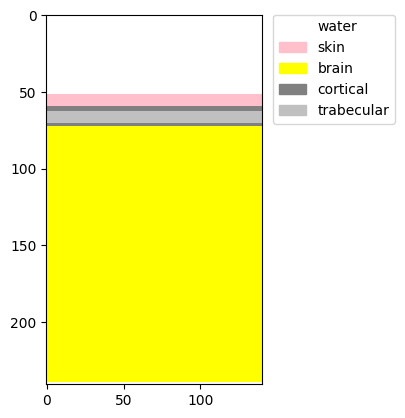

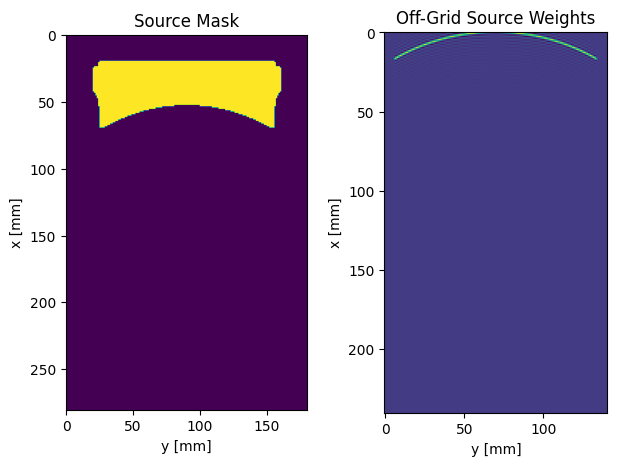

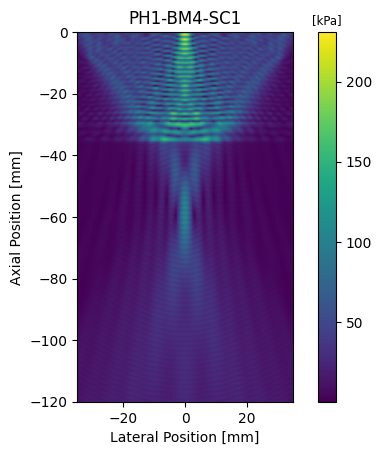

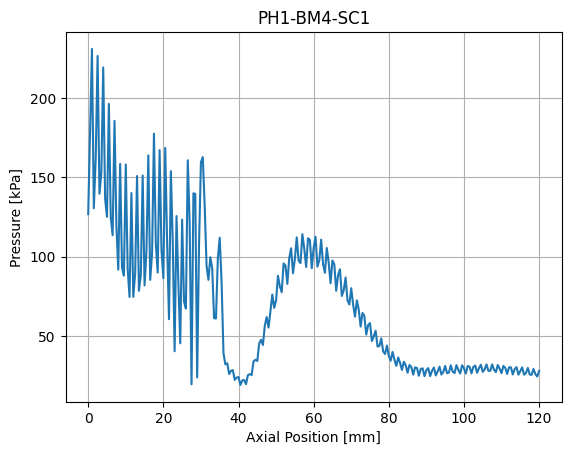

In [23]:
# =========================================================================
# VISUALIZATION
# =========================================================================

# sampling frequency
fs = 1.0 / kgrid.dt

# get Fourier coefficients
amp, _, _ = extract_amp_phase(sensor_data['p'].T, fs, freq, dim=1, fft_padding=1,
                              window='Rectangular')

# reshape to array
p = np.reshape(amp, (Nx, Nz), order='F')

# axes for plotting
x_vec = kgrid.x_vec
y_vec = kgrid.y_vec[0] - kgrid.y_vec

fig0, ax0 = plt.subplots(1, 1)
values = np.unique(sound_speed.ravel())
# get the colors of the values, according to the colormap used by imshow
colors = {1500.0: mcolors.to_rgb('#FFFFFF'),
          1610.0: mcolors.to_rgb('#FFC0CB'),
          1560.0: mcolors.to_rgb('#FFFF00'),
          2800.0: mcolors.to_rgb('#808080'),
          2300.0: mcolors.to_rgb('#C0C0C0')}
labels = {1500.0: 'water',
          1610.0: 'skin',
          1560.0: 'brain',
          2800.0: 'cortical',
          2300.0: 'trabecular'}
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in colors]
# put those patched as legend-handles into the legend
ax0.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
sos = np.array([[colors[i] for i in j] for j in sound_speed.T])  
im = ax0.imshow(sos, interpolation='none')
ax0.grid(False)
ax0.set_aspect('equal')

# get grid weights
grid_weights = karray.get_array_grid_weights(kgrid)
fig1, (ax1a, ax1b) = plt.subplots(1, 2)
#(1e3 * y_vec, 1e3 * x_vec, np.flip(source.p_mask, axis=0), shading='nearest')
ax1a.imshow(source.p_mask[:, :].T)
ax1a.set(xlabel='y [mm]', ylabel='x [mm]', title='Source Mask')
ax1b.imshow(grid_weights.T)
_ = ax1b.set_title('Off-Grid Source Weights')
plt.tight_layout(pad=1.2)

fig2, ax2 = plt.subplots(1, 1)
p2 = ax2.pcolormesh(1e3 * np.squeeze(x_vec),
                    1e3 * np.squeeze(y_vec),
                    np.flip(p.T, axis=1) / 1e3,
                    shading='gouraud', cmap='viridis')
ax2.set(xlabel='Lateral Position [mm]', ylabel='Axial Position [mm]', title='PH1-BM4-SC1')
ax2.set_aspect('equal')
cbar2 = fig2.colorbar(p2, ax=ax2)
_ = cbar2.ax.set_title('[kPa]', fontsize='small')

fig3, ax3 = plt.subplots(1, 1)
ax3.plot(-1e3 * y_vec, p[(Nx - 1) // 2, :] / 1e3)
ax3.set(xlabel='Axial Position [mm]', ylabel='Pressure [kPa]', title='PH1-BM4-SC1')
ax3.grid(True)

plt.show()